In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import torch
import torch.nn as nn
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")
from pinns import *
from local_utils import *

from pinns import *
from intro import *

In [2]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
dev_str = f"{device.type}:{device.index}"

In [4]:
import pickle
with open(f"./outputs/solution_1.pkl", "rb") as f:
    (run_params, params, solution) = pickle.load(f)
    
    
run_params = Struct(**run_params)
params = Struct(**params)

# Map the data points to their averages at the center of the grid.

noise level:0.05, A amplitude:6.545974046188106, B amplitude:2.3111067140215216, C amplitude:0.18693116796194387,
A noise std:0.32729870230940533, B noise std:0.11555533570107608, C noise std:0.009346558398097194.


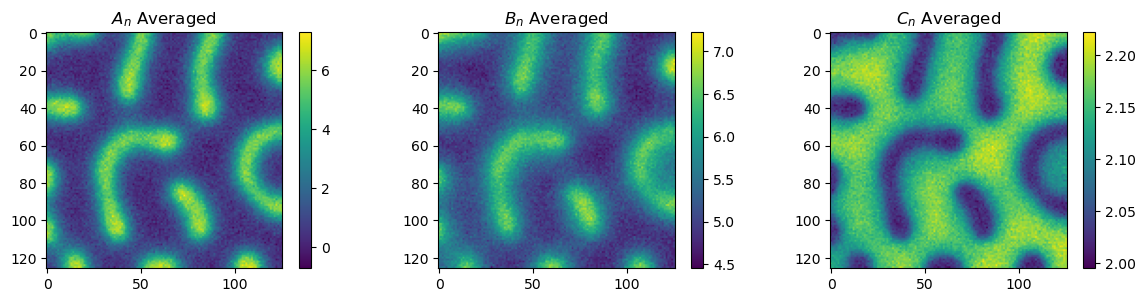

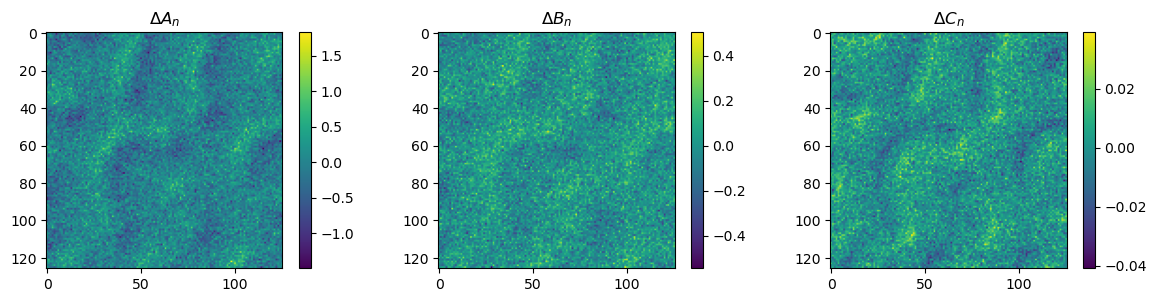

In [5]:
A_n = solution[1, 0, :, :]
B_n = solution[1, 1, :, :]
C_n = solution[1, 2, :, :]

#############################################################
#    Inner boundaries
# By using these slices, we can remove the boundary effects
# or select a smaller portion of the domain
#
#   Important: slices must not be larger than slices(1,-1,1).
#              Otherwise, the boundary effects of finit difference
#              Laplacian cannot be removed
#
x_slice = slice(1,-1, 1)
y_slice = slice(1,-1, 1)

to = create_to(A_n[x_slice,y_slice])

########################################
# Take the average of data points
kernel =np.array([[1, 1],
                  [1, 1]])


A_n = ndimage.convolve(A_n, kernel)/4
B_n = ndimage.convolve(B_n, kernel)/4
C_n = ndimage.convolve(C_n, kernel)/4

######################################
# Add noise to averaged mesh
noise_level = 0.05
ampA = np.max(A_n) - np.min(A_n)
ampB = np.max(B_n) - np.min(B_n)
ampC = np.max(C_n) - np.min(C_n)
print(f"noise level:{noise_level}, A amplitude:{ampA}, B amplitude:{ampB}, C amplitude:{ampC},")
print(f"A noise std:{ampA*noise_level}, B noise std:{ampB*noise_level}, C noise std:{ampC*noise_level}.")
np.random.seed(42)
A_n += np.random.normal(0,ampA*noise_level ,A_n.shape)
B_n += np.random.normal(0,ampB*noise_level ,B_n.shape)
C_n += np.random.normal(0,ampC*noise_level ,C_n.shape)
###################################
plot_n_im([A_n[x_slice,y_slice], 
           B_n[x_slice,y_slice], 
           C_n[x_slice,y_slice]], 
          [r"$A_{n}$ Averaged", r"$B_{n}$ Averaged", r"$C_{n}$ Averaged"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([A_n[x_slice,y_slice]-solution[1, 0, x_slice,y_slice],
           B_n[x_slice,y_slice]-solution[1, 1, x_slice,y_slice],
           C_n[x_slice,y_slice]-solution[1, 2, x_slice,y_slice]], 
          [r"$\Delta A_{n}$", r"$\Delta B_{n}$", r"$\Delta C_{n}$"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

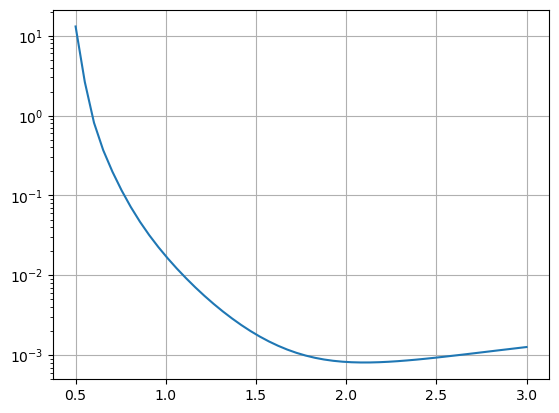

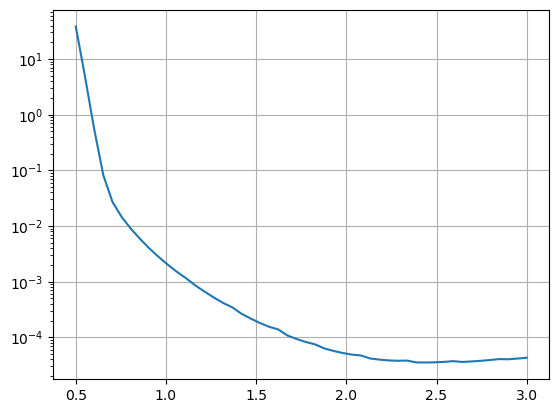

In [6]:
A_n_test2 = grad_diff(solution[1, 0, :,:])[x_slice,y_slice]
B_n_test2 = grad_diff(solution[1, 1, :,:])[x_slice,y_slice]

ss = np.linspace(5e-1, 3, 50)
stds_A= np.array([ np.mean( (ndimage.gaussian_laplace(A_n, sigma=s)[x_slice,y_slice]-A_n_test2)**2) 
                 for s in ss])
stds_B= np.array([ np.mean( (ndimage.gaussian_laplace(B_n, sigma=s)[x_slice,y_slice]-B_n_test2)**2) 
                 for s in ss])

plt.plot(ss, stds_A);plt.grid();plt.yscale('log');plt.show()
plt.plot(ss, stds_B);plt.grid();plt.yscale('log');plt.show()

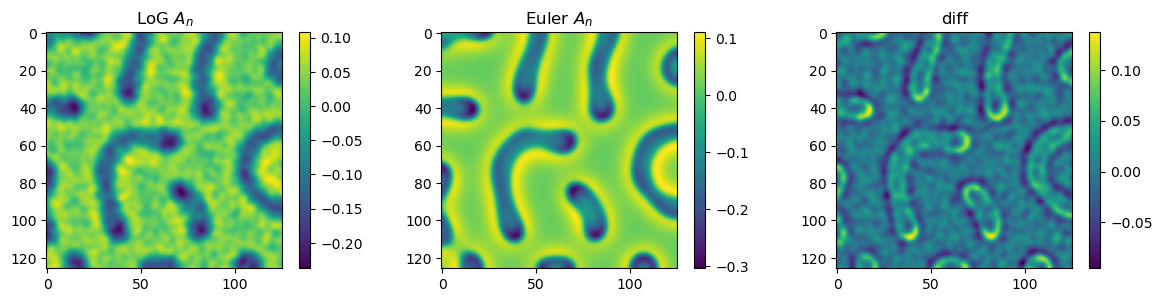

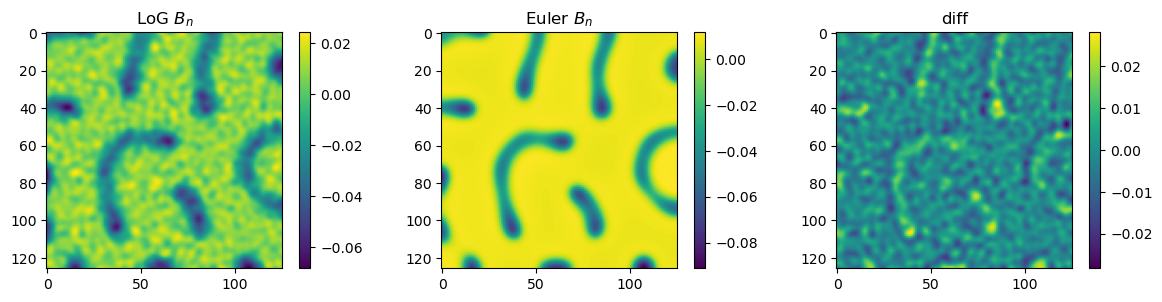

In [7]:
A_n_test = ndimage.gaussian_laplace(A_n, sigma=2.2)[x_slice,y_slice]
A_n_test2 = grad_diff(solution[1, 0, :,:])[x_slice,y_slice]

B_n_test = ndimage.gaussian_laplace(B_n, sigma=2.2)[x_slice,y_slice]
B_n_test2 = grad_diff(solution[1, 1, :,:])[x_slice,y_slice]
plot_n_im([A_n_test, A_n_test2,A_n_test-A_n_test2 ], 
          [r"LoG $A_{n}$", r"Euler $A_{n}$ ", "diff"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([B_n_test, B_n_test2,B_n_test-B_n_test2], 
          [r"LoG $B_{n}$", r"Euler $B_{n}$ ", "diff"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

Epoch: 1 
 data loss:3.460059, 
data A loss:3.192208, data B loss:0.264759, data C loss:0.003092, 
Laplacian A loss:126.620922, Laplacian B loss:6.325190

Validation loss:132.942028


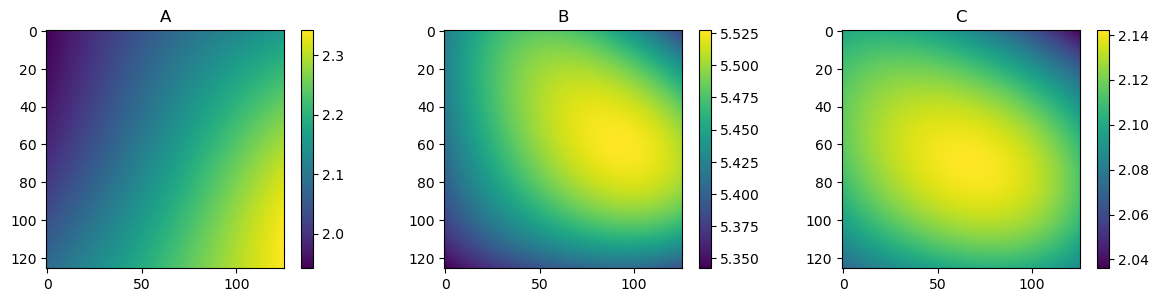

Earlt stop at epoch:124.
 Validation:9.091522783592744, averged validation:9.051759328987764


In [8]:
torch.manual_seed(42)
np.random.seed(42)

###########################################################
# Inputs
# restrict to inner boundaries
x = torch.linspace(0, run_params.Lx, run_params.Ix)[x_slice].to(device)
y = torch.linspace(0, run_params.Ly, run_params.Jy)[y_slice].to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')
data_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)
##########################################################
#   Data
# restrict to inner boundaries
data_A = torch.from_numpy(A_n[x_slice,y_slice].flatten()).to(device)
data_B = torch.from_numpy(B_n[x_slice,y_slice].flatten()).to(device)
data_C = torch.from_numpy(C_n[x_slice,y_slice].flatten()).to(device)
###########################################################
# LoG diffusion instead of Laplacians
# First, find the Laplacian of the Gaussian on the whole domain,
# then, select the inner boundaries. This way, the boundaries 
# effets removed
diffusion_scale_factor = (run_params.Ix*run_params.Jy/(run_params.Lx*run_params.Ly))
laplacianA = diffusion_scale_factor * ndimage.gaussian_laplace(A_n, sigma=2.2)
laplacianB = diffusion_scale_factor * ndimage.gaussian_laplace(B_n, sigma=2.2)

laplacianA = torch.tensor(laplacianA[x_slice,y_slice].flatten()).to(device)
laplacianB = torch.tensor(laplacianB[x_slice,y_slice].flatten()).to(device)
###########################################################
# Model
lb = torch.tensor([torch.min(x).item(), torch.min(y).item()]).to(device)
ub = torch.tensor([torch.max(x).item(), torch.max(y).item()]).to(device)
model = Net_dense_normalised([2, 64, 64, 3], lb, ub).to(device)
###########################################################
# optimizer
optimizer = torch.optim.LBFGS([*model.parameters()], lr=1
                             ,line_search_fn='strong_wolfe')#.Adam([*model.parameters()], lr=1e-3)#
###########################################################
# Train/Validation splits
#

# Data
max_index = data_X.shape[0]
All_indices = torch.randperm(max_index)
train_indices = All_indices[:max_index//16]#All_indices[:5*max_index//6]
validation_indices = All_indices[max_index//16:]#All_indices[5*max_index//6:]


data_X_train = data_X[train_indices,:]
data_X_validation = data_X[validation_indices,:]
data_A_train = data_A[train_indices]
data_A_validation = data_A[validation_indices]
data_B_train = data_B[train_indices]
data_B_validation = data_B[validation_indices]
data_C_train = data_C[train_indices]
data_C_validation = data_C[validation_indices]

# Laplacian
max_Laplacian_index = laplacianA.shape[0]
All_Laplacian_indices = torch.randperm(max_Laplacian_index)
train_Laplacian_indices = All_Laplacian_indices[:max_Laplacian_index//16]#[:5*max_Laplacian_index//6]
validation_Laplacian_indices = All_Laplacian_indices[max_Laplacian_index//16:]#[5*max_Laplacian_index//6:]

laplacianA_train = laplacianA[train_Laplacian_indices].to(device)
laplacianA_validation = laplacianA[validation_Laplacian_indices].to(device)
laplacianB_train = laplacianB[train_Laplacian_indices].to(device)
laplacianB_validation = laplacianB[validation_Laplacian_indices].to(device)


epochs = 3000
loss_data = 0.0
lambda_data = 1.0
loss_physics = 0.0
lambda_physics_laplacian = 1e-2

losses = np.zeros((5, epochs))
validations = np.zeros(epochs)

def act(x, km, n=2):
    return x**n / (x**n + km**n)

def inh(x, km, n=2):
    return  km**n / (x**n + km**n)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

for i in range(epochs):    
    def find_data_losses(data_X_input, data_A, data_B, data_C):
        #################################
        # data loss       
        data_f_hat = model(data_X_input).squeeze() 
        data_A_hat = data_f_hat[:,0]
        data_B_hat = data_f_hat[:,1]
        data_C_hat = data_f_hat[:,2]
        loss_A_data = torch.mean((data_A - data_A_hat)**2)
        loss_B_data = torch.mean((data_B - data_B_hat)**2)
        loss_C_data = torch.mean((data_C - data_C_hat)**2)
        return (loss_A_data,loss_B_data,loss_C_data)
                
    def find_Laplacian_losses(data_X_input, laplacianA, laplacianB,
                              laplacian_indices):
        #################################
        # physics derivatives
        #        
        physics_f = model(data_X_input).squeeze()         
        A_hat = physics_f[:,0]
        B_hat = physics_f[:,1]        
        # Note: The Laplacian is taken first on all points
        #       and then are selected for the given index
        #       The reason to do it this way is becuase of
        #       The laplacian bounderies effect that we need to remove
        laplacianA_hat = Laplacian(A_hat, data_X_input)
        laplacianB_hat = Laplacian(B_hat, data_X_input)
        
        laplacianA_hat = laplacianA_hat[laplacian_indices]
        laplacianB_hat = laplacianB_hat[laplacian_indices]
        
        A_loss_laplacian = torch.mean((laplacianA_hat-laplacianA)**2)
        B_loss_laplacian = torch.mean((laplacianB_hat-laplacianB)**2)                 
        ###############################
        return (A_loss_laplacian, B_loss_laplacian)
    
    # L-BFGS
    def closure():
        
        optimizer.zero_grad()
        (loss_A_data,loss_B_data,loss_C_data
        ) = find_data_losses(data_X_train,data_A_train,data_B_train,data_C_train)
                
        (A_loss_laplacian, B_loss_laplacian
        ) = find_Laplacian_losses(data_X, laplacianA_train,laplacianB_train,
                                  train_Laplacian_indices)
        
        loss_data = (loss_A_data + loss_B_data + loss_C_data)/3
        loss_laplacian_physics = A_loss_laplacian + B_loss_laplacian
        total_loss = (
            +lambda_data*loss_data            
            +lambda_physics_laplacian*loss_laplacian_physics
                        )

        total_loss.backward(retain_graph=True)
        
        
        losses[:,i] = (loss_A_data.item(), loss_B_data.item(), loss_C_data.item(), 
                       A_loss_laplacian.item(), B_loss_laplacian.item())                    
            
        return total_loss
    
    
    
    optimizer.step(closure)
    
    
    (validation_A_data,validation_B_data,validation_C_data,
     ) = find_data_losses(data_X_validation, 
                          data_A_validation,data_B_validation,data_C_validation)
                
    (A_validation_laplacian, B_validation_laplacian
    ) = find_Laplacian_losses(data_X, laplacianA_validation, laplacianB_validation,
                              validation_Laplacian_indices)
    
    validation_loss = (validation_A_data+validation_B_data+validation_C_data+
                       A_validation_laplacian+B_validation_laplacian).item()
    validations[i] = validation_loss
    
    # Early stop
    w = 50
    if i > w:
        if validations[i] > moving_average(validations[:i], w)[-1]:
            print(f"Earlt stop at epoch:{i+1}.\n"
                  f" Validation:{validations[i]}, averged validation:{moving_average(validations[:i], w)[-1]}")
            break    
    
    if (i+1)%200 == 0 or i==0 :
        print("============================================")
        print(f"Epoch: {i+1} \n data loss:{np.sum(losses[0:3,i]):.6f}, \n"
              f"data A loss:{losses[0,i]:.6f}, data B loss:{losses[1,i]:.6f}, data C loss:{losses[2,i]:.6f}, \n"
              f"Laplacian A loss:{losses[3,i]:.6f}, Laplacian B loss:{losses[4,i]:.6f}\n"
              f"\n"
              f"Validation loss:{validation_loss:.6f}"
             )
        data_f_hat = model(data_X)
        data_A_hat = data_f_hat[:,0]
        data_B_hat = data_f_hat[:,1]
        data_C_hat = data_f_hat[:,2]
        plot_n_im([to(data_A_hat.cpu().detach().numpy()), 
                   to(data_B_hat.cpu().detach().numpy()), 
                   to(data_C_hat.cpu().detach().numpy())], 
           ["A","B","C"],          
        figsize=(12, 3)); plt.tight_layout();plt.show()  
            
    

# Plot the trained outputs

A diff:0.13408041334867443 B diff:0.019820146974119792 C diff:0.00014943661062659882
F_A actual:0.020477020931113962, F_A:0.019186200574040413, RMSE: 0.053874156249461895
F_B actual:9.165338427760211, F_B:7.0376739501953125, RMSE: 0.9452001620546546
F_C actual:0.002602656210744512, F_C:0.0006514314445666969, RMSE: 0.057218948730543784

Laplacian A RMSE: 5.046427752038521
Laplacian B RMSE: 1.1994098381277798

dAdt RMSE: 0.0675905135388323
dBdt RMSE: 1.4589312785654134
dCdt RMSE: 0.057218948730543784


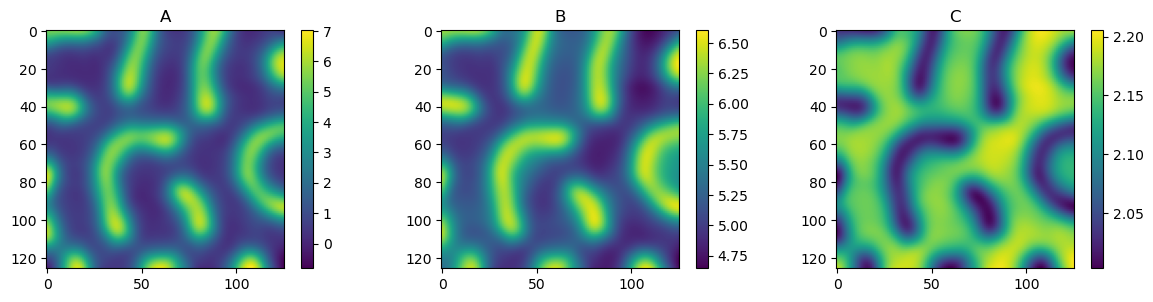

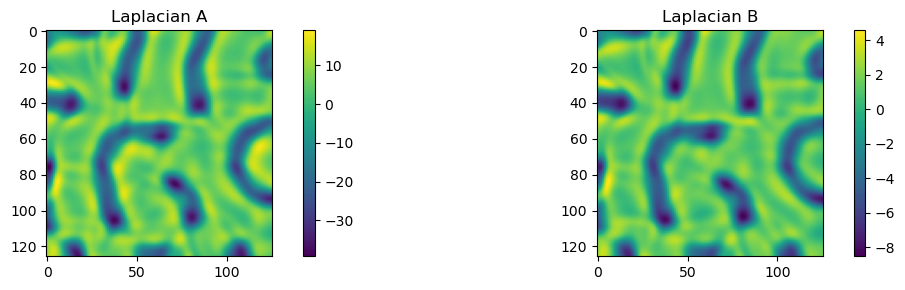

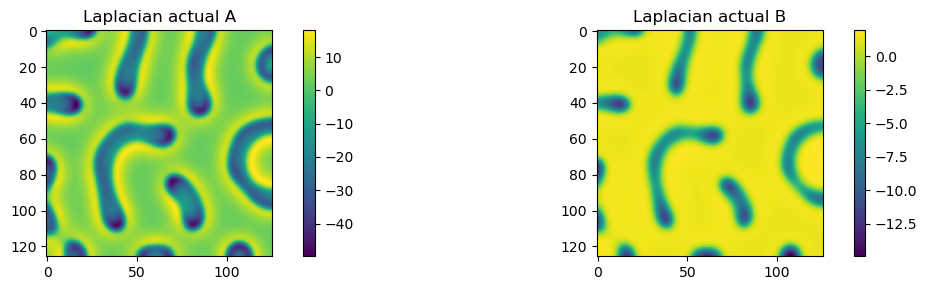

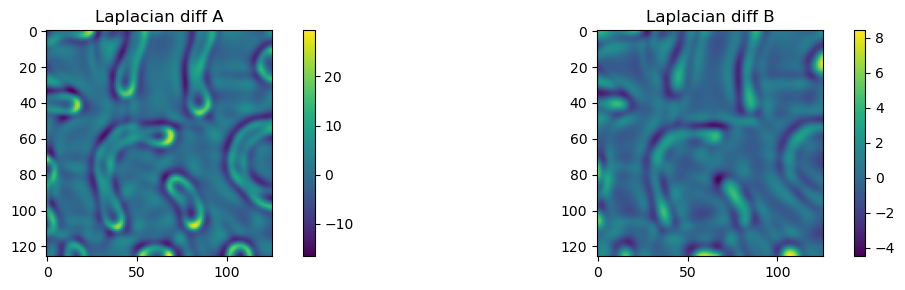

In [9]:
physics_f = model(data_X).squeeze()
A_hat = physics_f[:,0]
B_hat = physics_f[:,1]
C_hat = physics_f[:,2]

laplacianA_hat = Laplacian(A_hat, data_X)
laplacianB_hat = Laplacian(B_hat, data_X)

A_hat = to(A_hat.cpu().detach().numpy())
B_hat = to(B_hat.cpu().detach().numpy())
C_hat = to(C_hat.cpu().detach().numpy())
laplacianA_hat = to(laplacianA_hat.cpu().detach().numpy())
laplacianB_hat = to(laplacianB_hat.cpu().detach().numpy())


laplacianA = diffusion_scale_factor * grad_diff(solution[1, 0, :,:])[x_slice,y_slice]
laplacianB = diffusion_scale_factor * grad_diff(solution[1, 1, :,:])[x_slice,y_slice]

n = params["n"]

A_n_res = A_n[x_slice,y_slice]
B_n_res = B_n[x_slice,y_slice]
C_n_res = C_n[x_slice,y_slice]

F_A =  params["b_A"] + params["V_A"]*act(A_n_res, params["K_AA"], n)*inh(B_n_res, params["K_BA"], n) - params["mu_A"] * A_n_res
F_A_hat =  params["b_A"] + params["V_A"]*act(A_hat, params["K_AA"], n)*inh(B_hat, params["K_BA"], n) - params["mu_A"] * A_hat
F_B =  params["b_B"] + params["V_B"]*act(A_n_res, params["K_AB"], n)*inh(C_n_res, params["K_CB"], n) - params["mu_B"] * B_n_res
F_B_hat =  params["b_B"] + params["V_B"]*act(A_hat, params["K_AB"], n)*inh(C_hat, params["K_CB"], n) - params["mu_B"] * B_hat
F_C =  params["b_C"] + params["V_C"]*inh(A_n_res, params["K_AC"], n)*inh(B_n_res, params["K_BC"], n)*act(C_n_res, params["K_CC"], n) - params["mu_C"] * C_n_res
F_C_hat =  params["b_C"] + params["V_C"]*inh(A_hat, params["K_AC"], n)*inh(B_hat, params["K_BC"], n)*act(C_hat, params["K_CC"], n) - params["mu_C"] * C_hat


dAdt = params["D_A"]*laplacianA + F_A
dAdt_hat = params["D_A"]*laplacianA_hat + F_A_hat
dBdt = params["D_B"]*laplacianB + F_B
dBdt_hat = params["D_B"]*laplacianB_hat + F_B_hat

print(f"A diff:{np.mean((A_hat-A_n_res)**2)}",
      f"B diff:{np.mean((B_hat-B_n_res)**2)}",
      f"C diff:{np.mean((C_hat-C_n_res)**2)}")

print(f"F_A actual:{np.mean(F_A**2)}, F_A:{np.mean(F_A_hat**2)}, RMSE: {np.sqrt(np.mean((F_A - F_A_hat)**2))}")
print(f"F_B actual:{np.mean(F_B**2)}, F_B:{np.mean(F_B_hat**2)}, RMSE: {np.sqrt(np.mean((F_B - F_B_hat)**2))}")
print(f"F_C actual:{np.mean(F_C**2)}, F_C:{np.mean(F_C_hat**2)}, RMSE: {np.sqrt(np.mean((F_C - F_C_hat)**2))}")
      

print()
print(f"Laplacian A RMSE: {np.sqrt(np.mean((laplacianA_hat-laplacianA)**2))}")
print(f"Laplacian B RMSE: {np.sqrt(np.mean((laplacianB_hat-laplacianB)**2))}")

print()
print(f"dAdt RMSE: {np.sqrt(np.mean((dAdt-dAdt_hat)**2))}")
print(f"dBdt RMSE: {np.sqrt(np.mean((dBdt-dBdt_hat)**2))}")
print(f"dCdt RMSE: {np.sqrt(np.mean((F_C-F_C_hat)**2))}")

plot_n_im([A_hat, B_hat, C_hat], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()


plot_n_im([laplacianA_hat, laplacianB_hat], 
          ["Laplacian A", "Laplacian B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([laplacianA, laplacianB], 
          ["Laplacian actual A", "Laplacian actual B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([laplacianA_hat-laplacianA, laplacianB_hat-laplacianB], 
          ["Laplacian diff A", "Laplacian diff B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

# Plot losses

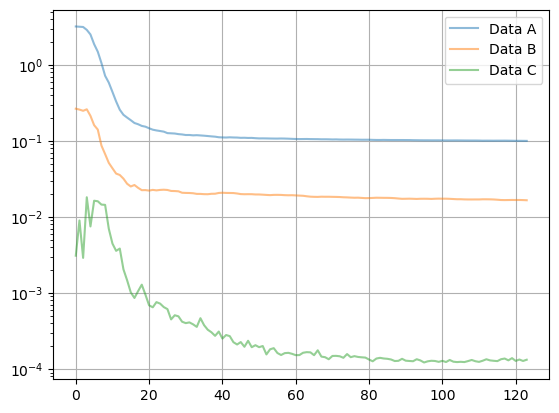

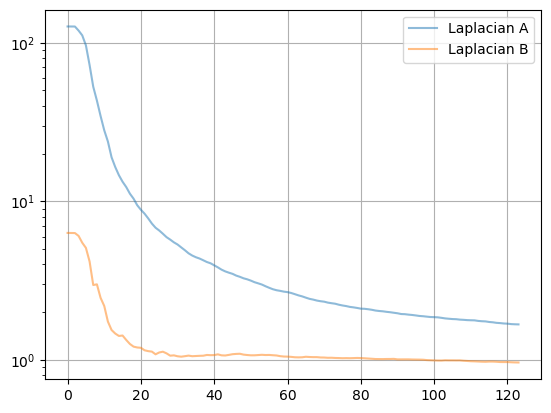

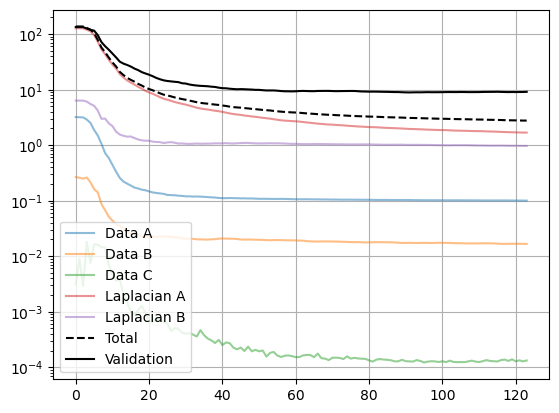

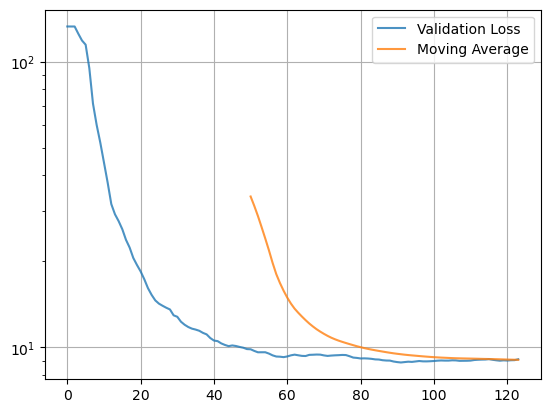

In [11]:
index = np.argwhere(losses[0,:] == 0)[0][0]
plt.plot(losses[0,:index], alpha=.5, label="Data A")
plt.plot(losses[1,:index], alpha=.5, label="Data B")
plt.plot(losses[2,:index], alpha=.5, label="Data C")
plt.yscale('log');plt.grid();plt.legend();plt.show()

plt.plot(losses[3,:index], alpha=.5, label="Laplacian A")
plt.plot(losses[4,:index], alpha=.5, label="Laplacian B")
plt.yscale('log');plt.grid();plt.legend();plt.show()


plt.plot(losses[0,:index], alpha=.5, label="Data A")
plt.plot(losses[1,:index], alpha=.5, label="Data B")
plt.plot(losses[2,:index], alpha=.5, label="Data C")
plt.plot(losses[3,:index], alpha=.5, label="Laplacian A")
plt.plot(losses[4,:index], alpha=.5, label="Laplacian B")
plt.plot(np.sum(losses[:,:index], axis=0), '--', alpha=1,color='black', label="Total")
plt.plot(validations[:index], alpha=1, color='black', label="Validation")
plt.yscale('log'); plt.grid();plt.legend();plt.show()

plt.plot(validations[:index], alpha=.8, label="Validation Loss")
plt.plot(range(w, index), moving_average(validations[:i], w), alpha=.8, label="Moving Average")

plt.yscale('log');plt.grid();plt.legend();plt.show()


 # Plot the trained Field and its difference

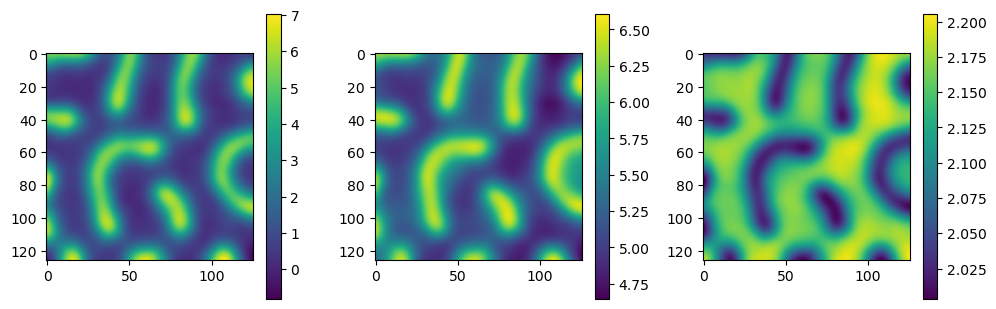

In [12]:
solution_hat = model(data_X).cpu().detach()
A_hat = to(solution_hat[:, 0].numpy())
B_hat = to(solution_hat[:, 1].numpy())
C_hat = to(solution_hat[:, 2].numpy())

_ = plt.figure(figsize=(10,6))
plt.subplot(131)
plt.imshow(A_hat)
plt.colorbar(shrink=.5)
plt.subplot(132)
plt.imshow(B_hat)
plt.colorbar(shrink=.5)
plt.subplot(133)
plt.imshow(C_hat)
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()

0.13408041334867443
0.019820146974119792
0.00014943661062659882


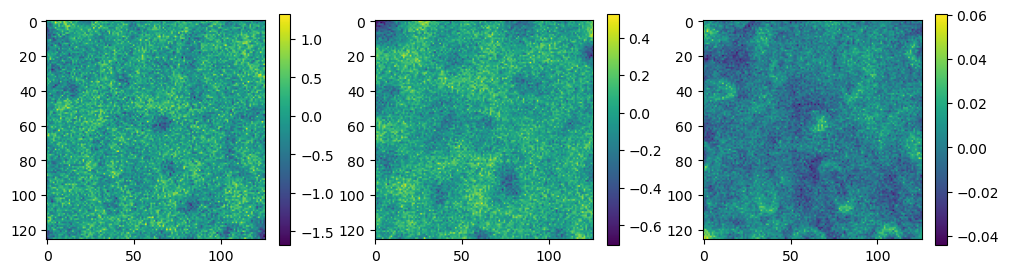

In [13]:
_ = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(A_hat-A_n[x_slice,y_slice])
print(np.mean((A_hat-A_n[x_slice,y_slice])**2))
plt.colorbar(shrink=.75)
plt.subplot(132)
plt.imshow(B_hat-B_n[x_slice,y_slice])
print(np.mean((B_hat-B_n[x_slice,y_slice])**2))
plt.colorbar(shrink=.75)
plt.subplot(133)
plt.imshow(C_hat-C_n[x_slice,y_slice])
print(np.mean((C_hat-C_n[x_slice,y_slice])**2))
plt.colorbar(shrink=.75)
plt.show()

# Second optimisation
## Find the parameters

In [14]:
def create_var(init=None):
    if init is None:
        return torch.nn.Parameter(torch.ones(1, requires_grad=True, device=dev_str))
    else:
        return torch.nn.Parameter(init*torch.ones(1, requires_grad=True, device=dev_str))


D_A=params["D_A"]#, sampled_D_A, sampled_D_A_grad = create_var()
D_B=params["D_B"]#, sampled_D_B, sampled_D_B_grad = create_var()
b_A = create_var()
b_B = create_var()
b_C = create_var()
V_A = create_var()
V_B = create_var()
V_C = create_var()
mu_A = create_var()
mu_B = create_var()
mu_C=params["D_A"]#, sampled_mu_C, sampled_mu_C_grad = create_var()
K_AA = create_var()
K_AB = create_var()
K_AC = create_var()
K_BA = create_var()
K_BC = create_var()
K_CB = create_var()
K_CC = create_var()
n = params['n']

params_name_list = [#"D_A", "D_B", 
                    "b_A", "b_B", "b_C", "V_A", "V_B", "V_C", "mu_A", "mu_B", #"mu_C",
                    "K_AA", "K_AB", "K_AC", "K_BA", "K_BC", "K_CB", 
                    "K_CC"
]

params_list = [#D_A, D_B, 
               b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, #mu_C,
               K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, 
               K_CC
]


In [15]:
   
def physics_loss():            
    physics_f = model(data_X).squeeze()
    A_hat = physics_f[:,0]
    B_hat = physics_f[:,1]
    C_hat = physics_f[:,2]
    
    laplacianA_hat = Laplacian(A_hat, data_X)
    laplacianB_hat = Laplacian(B_hat, data_X)    
    # To make sure the parameters stay positive, we use the exponential function    
    e = torch.exp
    F_A_hat =  e(b_A) + e(V_A)*act(A_hat, e(K_AA), n)*inh(B_hat, e(K_BA), n) - e(mu_A) * A_hat
    #f_A =  e(b_A)/(e(D_A)+1e-6) + e(V_A)*act(A, e(K_AA), n)*inh(B, e(K_BA), n)/(e(D_A)+1e-6) - e(mu_A)*A/(e(D_A)+1e-6)
    F_B_hat =  e(b_B) + e(V_B)*act(A_hat, e(K_AB), n)*inh(C_hat, e(K_CB), n) - e(mu_B) * B_hat
    #f_B =  e(b_B)/(e(D_B)+1e-6) + e(V_B)*act(A, e(K_AB), n)*inh(C, e(K_CB), n)/(e(D_B)+1e-6) - e(mu_B)*B/(e(D_B)+1e-6)
    F_C_hat =  e(b_C) + e(V_C)*inh(A_hat, e(K_AC), n)*inh(B_hat, e(K_BC), n)*act(C_hat, e(K_CC), n) - mu_C * C_hat

    
    #dAdt = e(D_A) * laplacianA + F_A
    dAdt = D_A * laplacianA_hat + F_A_hat
    #dAdt2 = laplacianA + f_A
    #dBdt = e(D_B) * laplacianB + F_B
    dBdt = D_B * laplacianB_hat + F_B_hat
    #dBdt2 = laplacianB + f_B
    dCdt = F_C_hat
    ################################
    # physics loss
    # Construct the physics loss here
    A_loss_physics = torch.mean(dAdt**2)
    #A2_loss_physics = torch.mean(dAdt2**2)
    B_loss_physics = torch.mean(dBdt**2)
    #B2_loss_physics = torch.mean(dBdt2**2)
    C_loss_physics = torch.mean(dCdt**2)
    return (A_loss_physics + B_loss_physics + C_loss_physics)


optimizer2 = torch.optim.LBFGS(params_list,
                               lr=1.,
                               history_size=10, 
                               max_iter=20, 
                               line_search_fn="strong_wolfe")

# L-BFGS
def closure():
    if torch.is_grad_enabled():
        optimizer2.zero_grad()
    loss = physics_loss()
    if loss.requires_grad:
        loss.backward()
    return loss

history_lbfgs = []
stored_parameters = np.zeros(len(params_list))
for i in range(20):
    history_lbfgs.append(physics_loss().item())
    if np.all([not np.isnan(p.item()) for p in params_list]):
        stored_parameters = [np.exp(p.item()) for p in params_list]
    else:
        print("Nan -- (maybe large learning rate)")
        break
        
    if i%1 ==0:
        print(history_lbfgs[-1],", ".join([f"{name}={np.exp(l.item()):.4f}" 
                 for l, name in zip(params_list, params_name_list)]))
        print()
    optimizer2.step(closure)


180.750244140625 b_A=2.7183, b_B=2.7183, b_C=2.7183, V_A=2.7183, V_B=2.7183, V_C=2.7183, mu_A=2.7183, mu_B=2.7183, K_AA=2.7183, K_AB=2.7183, K_AC=2.7183, K_BA=2.7183, K_BC=2.7183, K_CB=2.7183, K_CC=2.7183

0.6531492471694946 b_A=0.0651, b_B=0.8906, b_C=0.0440, V_A=2.9951, V_B=11.7740, V_C=2.4543, mu_A=0.0483, mu_B=0.5024, K_AA=4.1410, K_AB=4.7140, K_AC=2.6310, K_BA=4.2147, K_BC=1.8458, K_CB=8.6724, K_CC=3.7238

0.6311892867088318 b_A=0.0104, b_B=3.1976, b_C=0.0060, V_A=3.5256, V_B=11.9432, V_C=2.3416, mu_A=0.0134, mu_B=0.9426, K_AA=9.4398, K_AB=4.5665, K_AC=2.5922, K_BA=8.6033, K_BC=1.5444, K_CB=11.6891, K_CC=4.3083

0.625522255897522 b_A=0.0037, b_B=5.0418, b_C=0.0032, V_A=3.7819, V_B=12.4069, V_C=2.3185, mu_A=0.0119, mu_B=1.3053, K_AA=9.7435, K_AB=4.5123, K_AC=2.5844, K_BA=10.2861, K_BC=1.4889, K_CB=13.2655, K_CC=4.4249

0.6242528557777405 b_A=0.0014, b_B=4.8830, b_C=0.0053, V_A=3.2154, V_B=12.3687, V_C=2.3922, mu_A=0.0513, mu_B=1.2749, K_AA=6.9094, K_AB=4.5173, K_AC=2.6112, K_BA=6.9

In [16]:
{'b_A': 0.001,'b_B': 1.0,'b_C': 10.0,'V_A': 5.0,'V_B': 100.0,'V_C': 50.0,'mu_A': 0.1,'mu_B': 0.5,
 'K_AA': 5.0, 'K_AB': 10.0,'K_AC': 5.0,'K_BA': 5.0,'K_BC': 5.0, 'K_CB': 10.0,'K_CC': 5.0}

{'b_A': 0.001,
 'b_B': 1.0,
 'b_C': 10.0,
 'V_A': 5.0,
 'V_B': 100.0,
 'V_C': 50.0,
 'mu_A': 0.1,
 'mu_B': 0.5,
 'K_AA': 5.0,
 'K_AB': 10.0,
 'K_AC': 5.0,
 'K_BA': 5.0,
 'K_BC': 5.0,
 'K_CB': 10.0,
 'K_CC': 5.0}

In [17]:
estimated_params = dict()
index = -1#np.argmin(np.sum(losses, axis=0)[20:])# + losses.shape[1]
#for l, name in zip(params_list, params_name_list):    
for l, name in zip(params_list, params_name_list):    
    estimated_params[name] = np.exp(l.item())#np.mean(np.exp(l[50000:]))#

In [18]:
estimated_params

{'b_A': 0.006129473303461005,
 'b_B': 5.040803594149433,
 'b_C': 0.015378121586646367,
 'V_A': 3.02107075840597,
 'V_B': 12.408652274726856,
 'V_C': 2.457390624496231,
 'mu_A': 0.07617235919532978,
 'mu_B': 1.3052685837239217,
 'K_AA': 4.626335028539067,
 'K_AB': 4.511412395923054,
 'K_AC': 2.633533888798803,
 'K_BA': 5.220362843824576,
 'K_BC': 1.8642199888923487,
 'K_CB': 11.292071879039783,
 'K_CC': 3.639189677110519}

In [19]:
import pickle

torch.save(model.state_dict(), "./outputs/model_LBFGS_Field_only_non_stationary_noisy_5")
with open('./outputs/model_LBFGS_Field_only_non_stationary_noisy_5_params_name_list.npy', 'wb') as f:
    np.save(f, params_name_list)    
with open('./outputs/model_LBFGS_Field_only_non_stationary_noisy_5_losses.npy', 'wb') as f:
    np.save(f, losses)    
with open(f"./outputs/model_LBFGS_Field_only_non_stationary_noisy_5_estimated_params.pkl", "wb") as f:
    pickle.dump((dict(params), dict(estimated_params)), f) 